# Splane&Scube tutorial (1/2): Alignment of consecutive ST slices on human brain MERFISH dataset

July 2023

Dataset: 33 MERFISH slices of mouse brain ([here](https://zenodo.org/record/8167488))

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
import SPACEL
from SPACEL import Scube

## Spatial transcriptomic data import

The input data type of Scube is a list of anndata objects for each slice. The anndata objects of each slice must contain a column of spatial domain for alignment in ``.obs``.

In [3]:
adata = sc.read('../data/merfish_mouse_brain/merfish_mouse_brain.h5ad')
slices = ['mouse1_slice1', 'mouse1_slice10', 'mouse1_slice21', 'mouse1_slice31', 'mouse1_slice40', 'mouse1_slice50', 'mouse1_slice62',
 'mouse1_slice71', 'mouse1_slice81', 'mouse1_slice91', 'mouse1_slice102', 'mouse1_slice112', 'mouse1_slice122', 'mouse1_slice131', 'mouse1_slice153',
 'mouse1_slice162', 'mouse1_slice170', 'mouse1_slice180', 'mouse1_slice190', 'mouse1_slice200', 'mouse1_slice201', 'mouse1_slice212',
 'mouse1_slice221', 'mouse1_slice232', 'mouse1_slice241', 'mouse1_slice251', 'mouse1_slice260', 'mouse1_slice271', 'mouse1_slice283',
 'mouse1_slice291', 'mouse1_slice301', 'mouse1_slice313', 'mouse1_slice326']
adata_list=[]
for i in range(33):
    adata_list.append(adata[adata.obs['slice_id'] == slices[i]])
    adata_list[i].uns['spatial_domain_colors'] = pd.Series(np.unique(adata_list[i].obs.spatial_domain)).replace(dict(zip([4,1,6,2,3,5,0],['#aad466', '#f4ed27','#f9973f','#e76f5a','#40ecd4', '#a62098', '#a4bcda']))).values.flatten()
    adata_list[i].obs.spatial_domain = adata_list[i].obs.spatial_domain.astype('category')

Plot all raw slices stacked in a single figure. Cells colored by spatial domain.First, we define the color of each spatial domain.

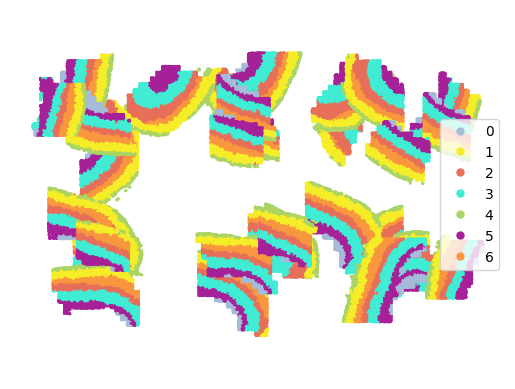

In [4]:
Scube.plot_stacked_slices(adata_list,spatial_key='spatial',cluster_key='spatial_domain')

## Pairwise alignment

Here, we perform pairwise alignment of slices. The ``cluster_key`` is a column of ``.obs`` which contain spatial domain information used for alignment. The ``n_neighbors`` affect how much neighbors are considered when calculate similarity of two slices. The ``knn_exclude_cutoff`` affect max distance of neighbors. By default, ``n_neighbors = 15`` and ``knn_exclude_cutoff = n_neighbors`` means a spot/cell in source slices consider 15 neighbors in target slices, and neighbor will be exclude when the distance of neighbors larger than the median of neareast 30 neighbors distance in all spot/cell in target slice. ``p`` affect the exponent of overlap penalty, and a larger p means stronger partial alignment capability.

In [5]:
Scube.align(adata_list,
      cluster_key='spatial_domain', 
      n_neighbors = 15, 
      n_threads=10,
      p=2,
      write_loc_path='Scube_outputs/aligned_coordinates.csv'
     )
sc.concat(adata_list).write('../data/merfish_mouse_brain/merfish_mouse_brain.h5ad')

Start alignment...
Alignment slice 1 to 0
Alignment slice 2 to 1
Alignment slice 3 to 2
Alignment slice 4 to 3
Alignment slice 5 to 4
Alignment slice 6 to 5
Alignment slice 7 to 6
Alignment slice 8 to 7
Alignment slice 9 to 8
Alignment slice 10 to 9
Alignment slice 11 to 10
Alignment slice 12 to 11
Alignment slice 13 to 12
Alignment slice 14 to 13
Alignment slice 15 to 14
Alignment slice 16 to 15
Alignment slice 17 to 16
Alignment slice 18 to 17
Alignment slice 19 to 18
Alignment slice 20 to 19
Alignment slice 21 to 20
Alignment slice 22 to 21
Alignment slice 23 to 22
Alignment slice 24 to 23
Alignment slice 25 to 24
Alignment slice 26 to 25
Alignment slice 27 to 26
Alignment slice 28 to 27
Alignment slice 29 to 28
Alignment slice 30 to 29
Alignment slice 31 to 30
Alignment slice 32 to 31
Runtime: 1890.87615275383 s


After alignment, the new spots/cells location coordinates saved in ``.obsm['spatial_aligned']`` of anndata object of each slices. When ``write_loc_path`` provied by users, the location coordinates of all spots/cells of all slices will be saved in ``write_loc_path``.

## Plot alignment results

Plot all aligned slices stacked in a single figure.

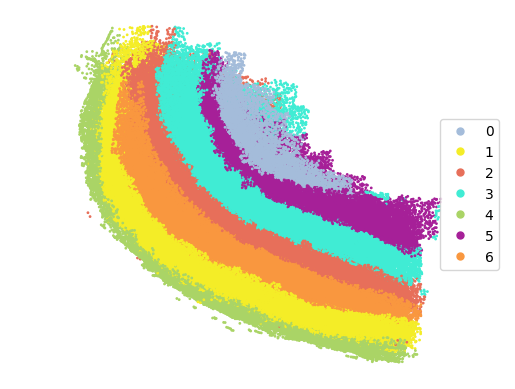

In [6]:
Scube.plot_stacked_slices(adata_list,spatial_key='spatial_aligned',cluster_key='spatial_domain')

Save all spots/cells aligned coordiantes and colors in a DataFrame.

In [7]:
coo = pd.DataFrame()
for i in range(len(adata_list)):
    loc = adata_list[i].obsm['spatial_aligned'].copy()
    loc['Z'] = i
    loc['celltype_colors'] = adata_list[i].obs['spatial_domain'].replace(dict(zip([4,1,6,2,3,5,0],['#aad466', '#f4ed27','#f9973f','#e76f5a','#40ecd4', '#a62098', '#a4bcda'])))
    coo = pd.concat([coo,loc],axis=0)
coo.to_csv('Scube_outputs/aligned_coordinates_colors.csv')

Plot all aligned slices stacked in 3D constructed by Scube

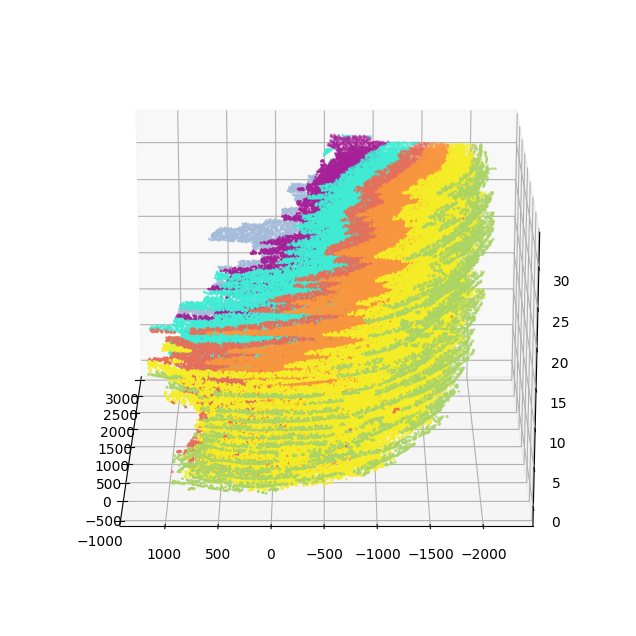

In [8]:
Scube.plot_3d(coo.values[:,:3],val=None,color=coo['celltype_colors'],show=True,elev=20,azim=180,s=1)